In [6]:
import os
import pickle
from tkinter import filedialog
from tkinter import Tk
import pandas as pd

root = Tk()
root.withdraw()

# Read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Sim_File_path = filedialog.askopenfilename(title="Select Sim-result file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Define data
df_setting = pd.read_excel(Setting_File_path)
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

df = pd.read_csv(csv_file_path)
dfsim = pd.read_csv(Sim_File_path)

# 壁温の初期値＝水温の初期値
initial_wall_temp = df.loc[0, 'TW']

# Mode check @ Real-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

feature_vars = ['TRQCRKENG', 'NE', 'TW']

print(feature_vars)

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']
['TRQCRKENG', 'NE', 'TW']


In [7]:
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
import os


def objective(trial, test_mode):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }
    
    all_rmse = []
    for mode in unique_modes:
        if mode == test_mode:
            continue
        
        mode_df = train_df[train_df['Mode'] == mode]
        X = mode_df[feature_vars]
        y = mode_df[target_variable]
        
        tscv = TimeSeriesSplit(n_splits=5)
        rmse = []
        for train_index, val_index in tscv.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_val)
            rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
        all_rmse.append(np.mean(rmse))
        
    return np.mean(all_rmse)

# すべてのモードでモデルのチューニングと評価を行う
for test_mode in unique_modes:
    params_file_path = f"{test_mode}_best_params.pkl"
    
    train_df = df[df['Mode'] != test_mode]
    test_df = df[df['Mode'] == test_mode]


 # ハイパーパラメータ(pklファイル)あれば読み込み、なければ計算
    if os.path.exists(params_file_path):
        with open(params_file_path, "rb") as f:
            best_params = pickle.load(f)
    else:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, test_mode), n_trials=2)
        best_params = study.best_params

        with open(params_file_path, "wb") as f:
            pickle.dump(best_params, f)

    # 最適なハイパーパラメータで最終モデルを訓練
    X_train_all = train_df[feature_vars]
    y_train_all = train_df[target_variable]
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train_all, y_train_all)
    
    # テストデータで評価
    X_test = test_df[feature_vars]
    y_test = test_df[target_variable]
    y_pred_test = final_model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Final RMSE for {test_mode}:", final_rmse)



ValueError: could not convert string to float: '#DIV/0!'

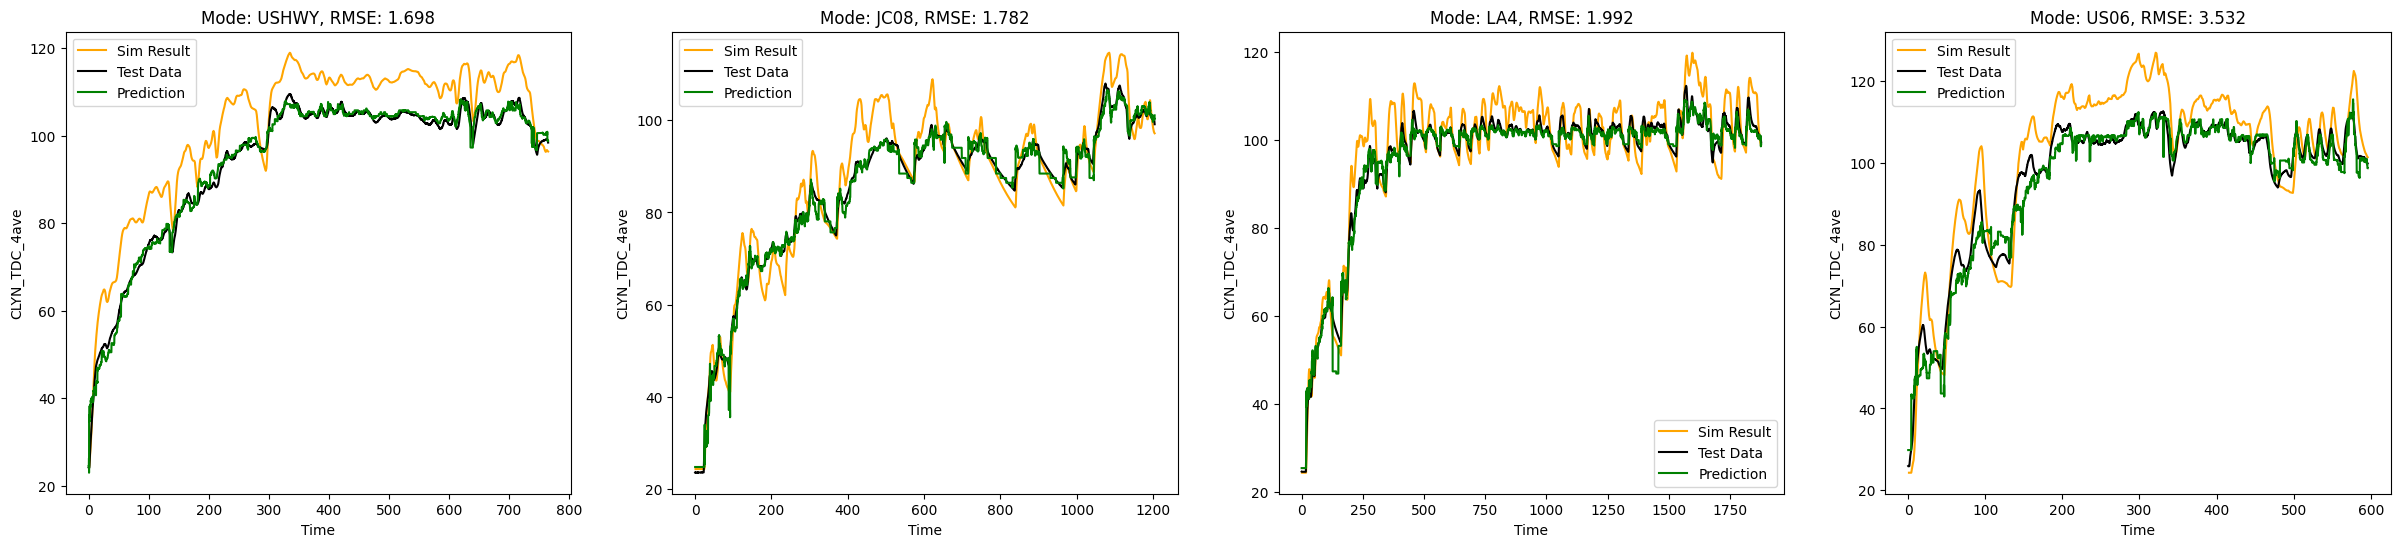

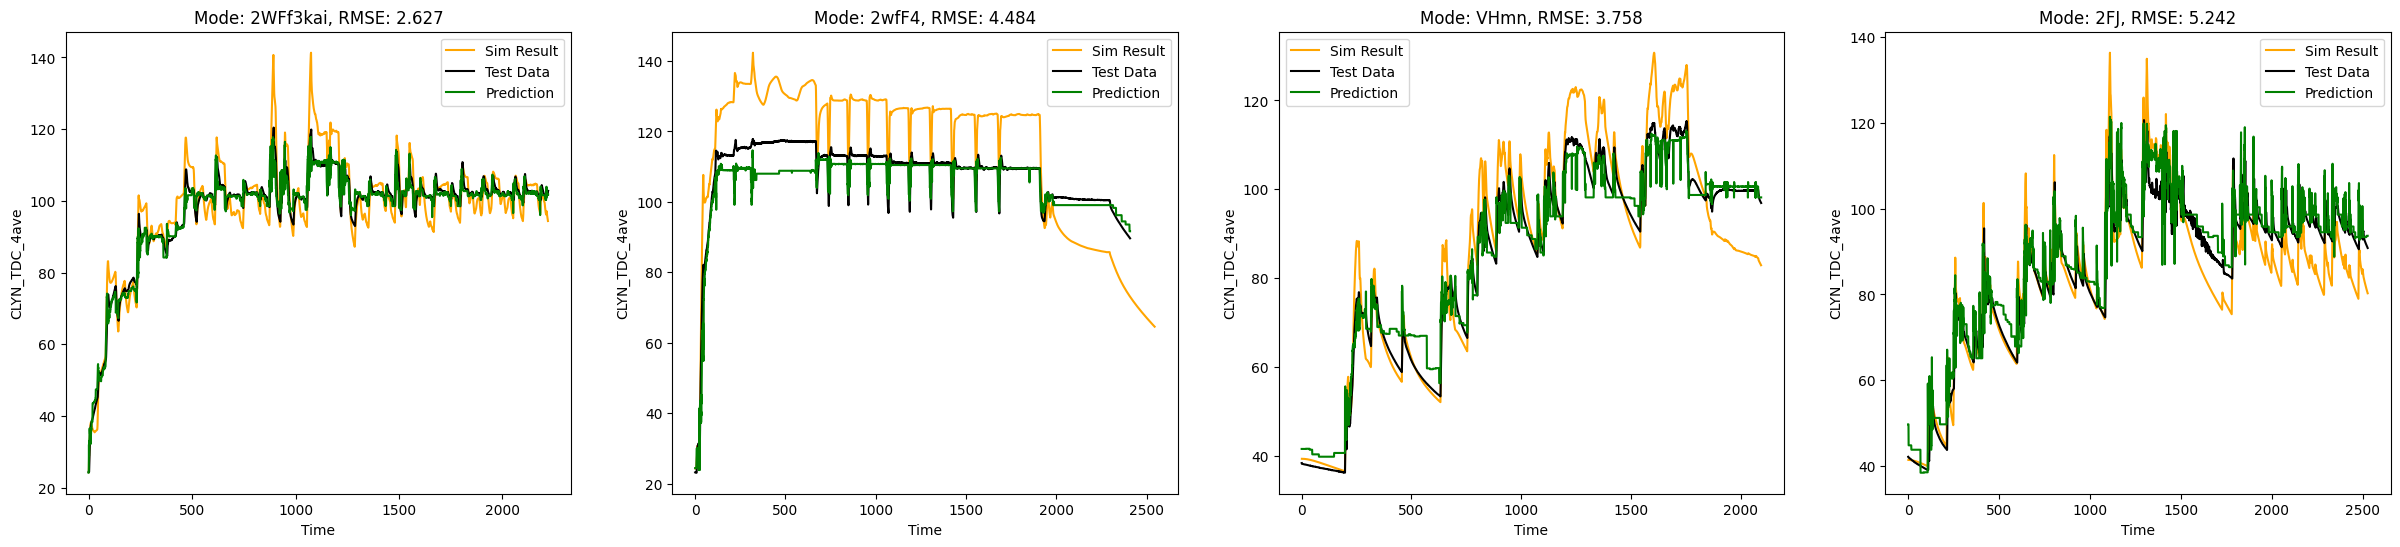

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# プロット初期化
fig, axs = plt.subplots(1, 4, figsize=(30, 6))
plot_count = 0

# 時間の差分を取得
time_steps = df['time'].diff().fillna(0).tolist()

# 積分を行うための関数を定義
def integrate_predictions(initial_value, deltas, time_steps):
    integrated = [initial_value]
    for i in range(1, len(deltas)):
        integrated_value = integrated[-1] + deltas[i] * (time_steps[i] - time_steps[i-1])
        integrated.append(integrated_value)
    return integrated


# すべてのモードに対して処理
for mode in unique_modes:
    # トレーニングデータとテストデータを分割
    train_df = df[df['Mode'] != mode]
    test_df = df[df['Mode'] == mode]

    # モデルのハイパーパラメータを読み込む
    params_file_path = f"{mode}_best_params.pkl"
    with open(params_file_path, "rb") as f:
        best_params = pickle.load(f)

    # 最適なハイパーパラメータでモデルを訓練
    X_train = train_df[feature_vars]
    y_train = train_df[target_variable]
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    # テストデータで評価
    X_test = test_df[feature_vars]
    y_test = test_df[target_variable]
    y_pred = model.predict(X_test)
    rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))

    # Sim data
    filter_dfsim = dfsim[dfsim['Mode'] == mode]
    sim_time_data = filter_dfsim["time"].iloc[:len(y_test)]
    sim_target = filter_dfsim[target_variable].iloc[:len(y_test)]

    # 予測結果を積分して時系列データを再構築
    integrated_wall_temp = integrate_predictions(initial_wall_temp, y_pred_test, time_steps)


    # 時系列データのプロット
    axs[plot_count].plot(sim_time_data, sim_target, label='Sim Result', color='orange')
    axs[plot_count].plot(test_df['time'], y_test, label='Test Data', color='black')
    axs[plot_count].plot(test_df['time'], integrated_wall_temp, label='Prediction', color='green')
    axs[plot_count].set_title(f'Mode: {mode}, RMSE: {rmse_val:.3f}')
    axs[plot_count].set_xlabel('Time')
    axs[plot_count].set_ylabel(target_variable)
    axs[plot_count].legend()

    plot_count += 1

    # 4つのプロットごとに図を表示
    if plot_count % 4 == 0 and plot_count != 0:
        plt.show()
        if mode != unique_modes[-1]:
            fig, axs = plt.subplots(1, 4, figsize=(30, 6))
            plot_count = 0
